<a href="https://colab.research.google.com/github/srdg/bangla-dl/blob/master/PyTorch_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Acquisition
Download the [CMATERdb](https://www.dropbox.com/s/55bhfr3ycvsewsi/CMATERdb%203.1.2.rar) pattern recognition database and clean up `/content` directory.

In [ ]:
!wget --quiet -O database.rar https://www.dropbox.com/s/55bhfr3ycvsewsi/CMATERdb%203.1.2.rar
!unrar x database.rar > /dev/null
!rm -rf database.rar sample_data
!mv BasicFinalDatabase/ data/

# Library imports
Import necessary libaries.  
We use `os` for listing files, `albumentations`, `numpy` and `PIL` for image processing, and `matplotlib` to display a subset of the images.

In [ ]:
import os

import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from PIL import Image
import albumentations as A

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchsummary import summary

# Exploratory Data Analysis
Let us see how many distinct classes we have. From the data it is already ascertained that we are working with `.bmp` images, which are bitmap images. Let us see how the images are defined in the dataset.

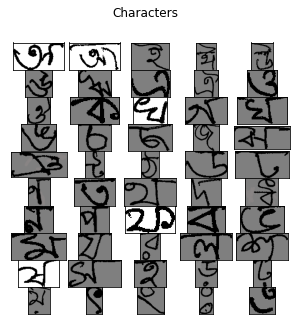

In [ ]:
imgs = []
for folder in sorted(os.listdir('data/Train')):
  imgs.append('data/Train/'+folder+'/bcc000000.bmp')

%matplotlib inline
fig = plt.figure(figsize=(5,5))
fig.suptitle('Characters')
for idx in range(50):
    image = Image.open(imgs[idx])
    image = np.array(image)
    # image = np.array(image)[...,0] # comment prev. line and uncomment this to view a single layer
    plt.subplot(10,5,idx+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, vmin=0, vmax=255)
    # plt.imshow(image, cmap='gray') # comment prev. line and uncomment this to view a single layer
    plt.subplots_adjust(hspace=0, wspace=0)
    
plt.show()

## Checking image-specific details
Looks like all images do not have the same dimensions. Let us see how many of them are unique and see a sample dimension.

In [ ]:
img_dims, files = [], []
for folder in sorted(os.listdir('data/Train')):
  tmp = ['data/Train/'+folder+'/'+i for i in sorted(os.listdir('data/Train/'+folder))]
  for i in tmp:
    files.append(i)
img_dims = [np.array(Image.open(i)).shape for i in files]
print("Among", len(img_dims), "images, there are", len(set(img_dims)), "unique dimensions.")
print("Sample dimension:", img_dims[0])

Among 12000 images, there are 4879 unique dimensions.
Sample dimension: (53, 98, 3)


### How does the image look in each layer?
It is a bitmap image with 3 layers. Let us look at each layer in a sample image individually and plot them to see if we can identify any discernible changes.

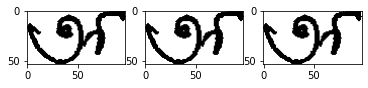

In [ ]:
f=files[0]
a=np.array(Image.open(f))
for i in range(a.shape[-1]):
  plt.subplot(1,3,i+1)
  plt.imshow(a[...,i], cmap='gray') # cmap has to be mentioned else plt will map with 'viridis' cmap

Interestingly, we see that there is no change in the image in each layer, it is simply stacked up! Maybe we can use a single layer to train a network in this case.

# Defining our labels
Define our labels in Unicode (UTF-8). We associate each directory with a class.

In [ ]:
classes = {
    172:"\u0985",
    173:"\u0986",
    174:"\u0987",
    175:"\u0988",
    176:"\u0989",
    177:"\u098a",
    178:"\u098b",
    179:"\u098f",
    180:"\u0990",
    181:"\u0993",
    182:"\u0994",
    183:"\u0995",
    184:"\u0996",
    185:"\u0997",
    186:"\u0998",
    187:"\u0999",
    188:"\u099a",
    189:"\u099b",
    190:"\u099c",
    191:"\u099d",
    192:"\u099e",
    193:"\u099f",
    194:"\u09a0",
    195:"\u09a1",
    196:"\u09a2",
    197:"\u09a3",
    198:"\u09a4",
    199:"\u09a5",
    200:"\u09a6",
    201:"\u09a7",
    202:"\u09a8",
    203:"\u09aa",
    204:"\u09ab",
    205:"\u09ac",
    206:"\u09ad",
    207:"\u09ae",
    208:"\u09af",
    209:"\u09b0",
    210:"\u09b2",
    211:"\u09b6",
    212:"\u09b7",
    213:"\u09b8",
    214:"\u09b9",
    215:"\u09dc",
    216:"\u09dd",
    217:"\u09df",
    218:"\u09ce",
    219:"\u0982",
    220:"\u0983",
    221:"\u0981",
    }
print("Classes to train:", end=" ")
for i in list(classes.keys()):
  print(classes[i], end=" ")
print()
print("Number of distinct classes:", len(list(classes.keys())))

Classes to train: অ আ ই ঈ উ ঊ ঋ এ ঐ ও ঔ ক খ গ ঘ ঙ চ ছ জ ঝ ঞ ট ঠ ড ঢ ণ ত থ দ ধ ন প ফ ব ভ ম য র ল শ ষ স হ ড় ঢ় য় ৎ ং ঃ ঁ 
Number of distinct classes: 50


# Preparing file lists
We define the list of files to be used for training and testing.

In [ ]:
train_files, test_files = [], []

for mode in ['Train', 'Test']:
  for folder in sorted(os.listdir('data/'+mode)):
    tmp = ['data/'+mode+'/'+folder+'/'+i for i in sorted(os.listdir('data/'+mode+'/'+folder))]
    for i in tmp:
      if 'Train' in mode:
        train_files.append(i)
      else:
        test_files.append(i)

# Defining the dataset

We design a custom dataset to read and help in loading the files.

In [ ]:
class CharacterDataSet(Dataset):

  def __init__(self, files, transform=None):
    self.files = files
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    image = Image.open(files[idx])
    label = int(files[idx].split('/')[2]) # data/Train/172/bcc000000.bmp --> class 172, label 0
    image = np.array(image)[...,0]
    if self.transform:
      image = self.transform(image=image)["image"]
      # manual transform (binary thresholding) since library does not support this
      # see section "Checking threshold for binarizing images"
      # image = cv.threshold(image, 126, 255, cv.THRESH_BINARY)[1] # uncomment to apply 
    image = image[..., np.newaxis]
    image = image /255.0
    sample = (image, label-172)
    return sample

# Transforms and DataLoaders
Here, we attempt to define the image transforms needed for augmentation, following which, we define the dataset objects and use them to create data loader to help in the training and testing procedure.

In [ ]:
transforms = A.Compose([A.Resize(32,32)])
training_data = CharacterDataSet(train_files, transform=transforms)
testing_data = CharacterDataSet(test_files, transform=transforms)

In [ ]:
batch_size = 32
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

# Visualizing batches
Let us try to see a sample training batch and a sample testing batch. We will also use our pre-defined `labels` dictionary to identify the labels, and use a custom `Kalpurush` font to print the UTF-8 character labels on a `matplotlib` figure.

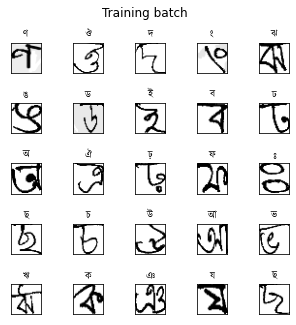

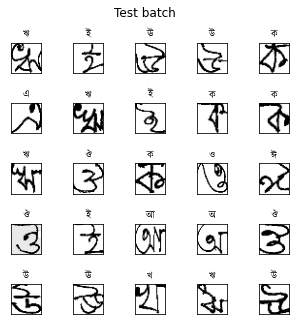

In [ ]:
!wget --quiet -O kalpurush.ttf https://www.omicronlab.com/download/fonts/kalpurush.ttf
%matplotlib inline
prop = fm.FontProperties(fname='kalpurush.ttf')
fig_idx=1
for loader in [train_dataloader, test_dataloader]:
  fig = plt.figure(fig_idx, figsize=(5,5))
  fig.suptitle('Training batch' if fig_idx is 1 else 'Test batch')
  fig_idx+=1
  x,y=None,None
  for X, Y in loader:
    x=X
    y=Y
    break
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(hspace=1, wspace=1)
    # print(classes[y[i].numpy().tolist()], end=" ")
    plt.title(classes[y[i].numpy().tolist()+172], fontproperties=prop)
    plt.imshow(x[i].squeeze(), cmap='gray')
  plt.show()

In [ ]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.batch_size = batch_size
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3,padding=0)
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    self.drop1 = nn.Dropout(p=0.2)
    self.fc1 = nn.Linear(in_features=2304, out_features=128)
    self.fc2 = nn.Linear(in_features=128,out_features=50)

  def forward(self, x):
    x = self.conv1(x.float())
    x = F.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = self.drop1(x)
    x = x.view(x.size(0),-1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    return x

In [62]:
def train(dataloader, model, loss_fn, optimizer):

  size = len(dataloader.dataset)

  for batch, data in enumerate(dataloader):

    inputs, labels = data

    inputs = np.transpose(inputs, (0,3,1,2))

    pred = model(inputs)
    loss = loss_fn(pred, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if batch%100==0:
        loss, current = loss.item(), batch*len(X)
        print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  test_loss, correct = 0,0

  with torch.no_grad():
    for X, y in dataloader:
      X = np.transpose(X, (0,3,1,2))
      pred = model(X.float())
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= size
  correct /= size
  print(f"Test Error : \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

In [63]:
net = Network()
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
num_epochs = 20
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}\n------------------------")
  train(train_dataloader, net, loss_fn, optimizer)
  test(test_dataloader, net, loss_fn)
print("Done!")
  

Epoch 1
------------------------
loss: 3.913020 [    0/12000]
loss: 3.918067 [ 3200/12000]
loss: 3.912419 [ 6400/12000]
loss: 3.917102 [ 9600/12000]
Test Error : 
 Accuracy: 0.1%, Avg loss: 0.122315

Epoch 2
------------------------
loss: 3.912214 [    0/12000]
loss: 3.904373 [ 3200/12000]
loss: 3.910518 [ 6400/12000]
loss: 3.914772 [ 9600/12000]
Test Error : 
 Accuracy: 0.2%, Avg loss: 0.122289

Epoch 3
------------------------
loss: 3.905513 [    0/12000]
loss: 3.917099 [ 3200/12000]
loss: 3.916120 [ 6400/12000]
loss: 3.907572 [ 9600/12000]
Test Error : 
 Accuracy: 0.3%, Avg loss: 0.122270

Epoch 4
------------------------
loss: 3.914808 [    0/12000]
loss: 3.914332 [ 3200/12000]
loss: 3.920488 [ 6400/12000]
loss: 3.917935 [ 9600/12000]
Test Error : 
 Accuracy: 0.5%, Avg loss: 0.122257

Epoch 5
------------------------
loss: 3.903957 [    0/12000]
loss: 3.921300 [ 3200/12000]
loss: 3.911097 [ 6400/12000]
loss: 3.901563 [ 9600/12000]
Test Error : 
 Accuracy: 0.6%, Avg loss: 0.122246



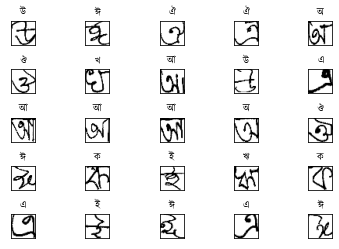

In [64]:
dataiter = iter(test_dataloader)
images, gt = dataiter.next()
# print(gt,len(gt))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.subplots_adjust(hspace=1, wspace=1)
  # print(classes[y[i].numpy().tolist()], end=" ")
  plt.title(classes[gt[i].numpy().tolist()+172], fontproperties=prop)
  plt.imshow(images[i].squeeze(), cmap='gray')
plt.show()

In [65]:
outputs = net(np.transpose(images, (0,3,1,2)))
_, predicted = torch.max(outputs, 1)
predicted = predicted[:25]
# print([labels[i.numpy().tolist()+172] for i in predicted])
print("Predicted : ",' '.join([classes[i.numpy().tolist()+172] for i in predicted]))
print("Expected :  ", ' '.join([classes[i.numpy().tolist()+172] for i in gt[:25]]))

Predicted :  ঔ ঔ ঔ ড় ঔ ঔ ঋ ঔ ঔ ছ ঔ ঋ ক ঔ ঋ ঋ ঔ ছ ঋ ঔ ঔ ঔ ঔ ঔ ড়
Expected :   উ ঈ ঐ ঐ অ ঔ খ আ উ এ আ আ আ অ ঔ ঈ ক ই ঋ ক এ ই ঈ এ ঈ


In [66]:
correct = 0
total = 0
with torch.no_grad():
  for data in test_dataloader:
    image, labels = data
    outputs = net(np.transpose(images[:25], (0,3,1,2)))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted==labels[:25]).sum().item()

print("Accuracy of network: %d%%" % (100 * correct / total)) 

Accuracy of network: 5%


<div align="center"><h1>Debug & Experimentation</h1>
<p>The following region is used for doing experiments on the dataset and is not part of the training procedure.</p></div>

# Rough Network Design
Points to note :
+ The `Conv2d` only supports `TensorFloat32`. Hence, conversion to `x.float()` is necessary.
+ To multiply 2 matrices, their dimensions must be of form `(a,b)` and `(b,c)`, such that the resultant matrix will have dimension `(a,c)`.
+ The `Conv2d` takes in data of the shape `(N, C, H, W)` where
 * N = Number of samples (batch size)
 * C = Number of channels in each sample
 * H = Height of each sample
 * W = Width of each sample
+ The end result should be of dimension `(N, C)` where
 * N = Number of samples (batch size)
 * C = Number of output features
+ During flattening of the final convolved and downsampled layer, `torch.view(prev_layer.shape(0),-1)` should be used. Note the `shape(0)`. `-1` is a wildcard. Intutitively, this results in a matrix of shape `(N, F)` where `N = prev_layer.shape(0) = batch size` and `F = number of features available for each sample`.  

In [ ]:
# Refer https://datascience.stackexchange.com/questions/70086
x, y = None, None
for batch, data in enumerate(train_dataloader, 0):
  x,y = data
print("Form (N, H, W, C_in):",x.shape) # --> transpose to form (N, C_in, H, W)
x = np.transpose(x, (0,3,1,2))
print("Form (N, C_in, H, W):",x.shape)
# x = torch.randn(1, 1, 28, 28)
conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=0)(x.float())
print("Convolved layer 1:",conv1.shape)
pool1 = torch.nn.MaxPool2d(kernel_size=2)(conv1)
print("Pooled layer 1:",pool1.shape)
conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)(pool1)
print("Convolved layer 2:",conv2.shape)
pool2 = torch.nn.MaxPool2d(kernel_size=2)(conv2)
print("Pooled layer 2:",pool2.shape)
drop1 = torch.nn.Dropout(p=0.2)
pool2 = drop1(pool2)
print("Dropped layer 2:",pool2.shape)
flat1 = pool2.view(pool2.size(0),-1)
print("Flattened layer 1:", flat1.shape)
fc1 = torch.nn.Linear(2304, 128)(flat1)
print("Fully connected layer 1:", fc1.shape)
fc2 = torch.nn.Linear(128, 50)(fc1)
print("Fully connected layer 2:", fc2.shape)
softmax = torch.nn.Softmax(fc2)

Form (N, H, W, C_in): torch.Size([32, 32, 32, 1])
Form (N, C_in, H, W): torch.Size([32, 1, 32, 32])
Convolved layer 1: torch.Size([32, 32, 30, 30])
Pooled layer 1: torch.Size([32, 32, 15, 15])
Convolved layer 2: torch.Size([32, 64, 13, 13])
Pooled layer 2: torch.Size([32, 64, 6, 6])
Dropped layer 2: torch.Size([32, 64, 6, 6])
Flattened layer 1: torch.Size([32, 2304])
Fully connected layer 1: torch.Size([32, 128])
Fully connected layer 2: torch.Size([32, 50])


# Checking threshold for binarizing images
There are instances when the images contain the values `[0,127,255]` instead of `[0,255]` only. In such cases, we determine the thresholding value as 126 for the tests to be successful. Comment out the manual thresholding line in the CharacterDataset class if this transform is not to be applied.

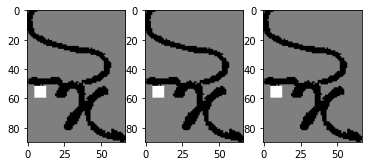

The original image has unique values as [0, 127, 255]


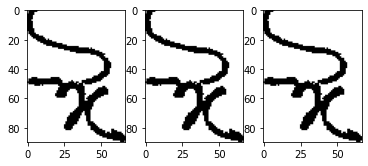

In [ ]:
root = 'data/Test/175/bcc000001.bmp'
img = np.array(Image.open(root))
fig = plt.figure(1)
for i in range(img.shape[-1]):
  plt.subplot(1,3,i+1)
  plt.imshow(img[...,i], cmap='gray')
plt.show()
print("The original image has unique values as",np.unique(img[...,0]).tolist())
img = cv.threshold(img, 126, 255, cv.THRESH_BINARY)[1]
fig = plt.figure(2)
for i in range(img.shape[-1]):
  plt.subplot(1,3,i+1)
  plt.imshow(img[...,i], cmap='gray')
plt.show()

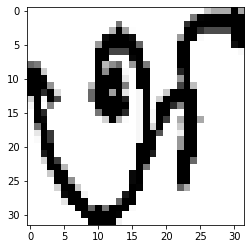

In [ ]:
transform = A.Compose([A.Resize(32,32)])

img_file = train_files[0]
img_arr = np.array(Image.open(img_file))[...,0]
img_arr = img_arr[..., np.newaxis]

transformed = transform(image=img_arr)
img_arr = transformed["image"]
img_arr = img_arr/255.0
unique, counts = np.unique(img_arr, return_counts=True)
img_hist = dict(zip(unique, counts))
plt.imshow(np.squeeze(img_arr), cmap='gray')